# Lab 07: Genetic Algorithms

## Total: 50 points

In this lab, you'll explore the fundamentals of genetic algorithms by implementing core operations like selection, crossover, and mutation. We give you the initialization code and fitness function so you can focus the different ways to implement core operations.

## General Instructions

- Carefully read through the commented helper functions.
- Implement the missing functions where marked with `pass`.
- This lab is VERY open ended! There isn't one way to do this. Implement the strategies or verisons that interest you!
- **We have provided suggested parameters to pass into the unimplemented functions, but depending on the methods you pick, the parameters might change or you will need additional ones. Make sure to edit the parameter list for methods and strategies you use!!** 

In [1]:
import random
import matplotlib.pyplot as plt
import time

In [2]:
# Problem Constants
NUM_PEOPLE = 5
SHIFTS_PER_DAY = 3
DAYS_PER_WEEK = 7
SHIFTS_PER_WEEK = SHIFTS_PER_DAY * DAYS_PER_WEEK # 21

In [3]:
# GA Parameters
POPULATION_SIZE = 100       # Number of schedules in each generation
GENERATIONS = 150           # Number of generations to run
MUTATION_RATE = 0.02        # Probability of a single bit flip mutation
CROSSOVER_RATE = 0.7        # Probability that crossover occurs between two parents
HARD_PENALTY = -2           # Penalty per violated hard constraint
SOFT_PENALTY = -1           # Penalty per violated soft constraint

# Helper Functions

In [4]:
## Helper Functions
def get_shift_details(shift_index):
    """
    Calculates day (0-6) and shift type (0=M, 1=A, 2=N) from shift index (0-20).

    Args:
        shift_index (int): The shift index (0-20)

    Returns:
        day (int): The day of the week (0-6)
        shift_type (int): The shift type (0=M, 1=A, 2=N)
    """
    if not (0 <= shift_index < SHIFTS_PER_WEEK):
        raise ValueError(f"shift_index {shift_index} out of range [0, {SHIFTS_PER_WEEK-1}]")
    day = shift_index // SHIFTS_PER_DAY
    shift_type = shift_index % SHIFTS_PER_DAY
    return day, shift_type

def print_schedule(schedule, fitness):
    """
    Prints the schedule in a readable format.

    Args:
        schedule (list): The schedule to print
        fitness (float): The fitness score of the schedule
    """
    print(f"\nSchedule (Fitness: {fitness:.2f}):")
    days = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
    shifts = ["M", "A", "N"]
    header = "      " + " | ".join([days[d] for d in range(DAYS_PER_WEEK)])
    print(header)
    subheader = "      " + " ".join([f"{s}" for _ in days for s in shifts])
    print(subheader)
    print("      " + "-" * (len(subheader)-1))
    for person_idx, person_schedule in enumerate(schedule):
        schedule_str = ""
        for i in range(SHIFTS_PER_WEEK):
             schedule_str += str(person_schedule[i])
             if (i + 1) % SHIFTS_PER_DAY == 0 and i < SHIFTS_PER_WEEK - 1:
                 schedule_str += " " # Add space between days
        print(f"ATC {person_idx+1}: {schedule_str}")
    print("-" * (len(subheader) + 5))

def plot_fitness(best_fitness_history, avg_fitness_history=None):
    """
    Plots the best and average fitness score per generation.

    Args:
        best_fitness_history (list): A list of best fitness scores for each generation
        avg_fitness_history (list, optional): A list of average fitness scores for each generation

    Returns:
        None
    """
    plt.figure(figsize=(12, 6))
    generations = range(1, len(history) + 1)
    plt.plot(generations, history, marker='o', linestyle='-', label='Best Fitness')
    
    if avg_history:
        plt.plot(generations, avg_history, marker='.', linestyle='--', label='Average Fitness')
    
    plt.title('GA Fitness Progression for ATC Scheduling')
    plt.xlabel('Generation')
    plt.ylabel('Fitness Score (Higher is Better)')
    min_fitness = min(history)
    if avg_history:
        min_fitness = min(min_fitness, min(avg_history))
    plt.ylim(bottom=min(min_fitness - 5, -50))
    plt.legend()
    plt.grid(True)
    plt.show()


## Initialization

Helper code to create the initial population. Make sure you understand how we have chosen to represent the individual and population!

In [5]:
# Init GA
def generate_initial_representation(num_people, shifts_per_week):
  """
  Creates a single random schedule representation (chromosome).
  Each person gets a list of 0s and 1s for the week's shifts.

  Args:
    num_people (int): The number of people in the schedule.
    shifts_per_week (int): The number of shifts per week.

  Returns:
    schedule (list): A list of lists, where each inner list represents a person's schedule for the week.
  """
  schedule = []
  for _ in range(num_people):
    person_schedule = [random.choice([0, 1]) for _ in range(shifts_per_week)]
    schedule.append(person_schedule)
  return schedule

def generate_population(population_size, num_people, shifts_per_week):
  """ Creates the initial population of random schedules. """
  return [generate_initial_representation(num_people, shifts_per_week)
          for _ in range(population_size)]

## Fitness Function

Evaluate how close a candidate is to the target solution. Note how hard versus soft constraints are handled.

In [6]:
def evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day):
    """ 
    Calculates the fitness of a single schedule based on constraints. 

    Args:
        schedule (list): The schedule to evaluate
        num_people (int): The number of people in the schedule
        shifts_per_week (int): The number of shifts per week
        shifts_per_day (int): The number of shifts per day

    Returns:
        fitness (float): The fitness score of the schedule
    """
    fitness = 0 # Start with perfect fitness, subtract penalties

    # Hard Constraint Checks

    # 1. Minimum controllers per shift
    min_controllers = {0: 1, 1: 2, 2: 1} # M:1, A:2, N:1
    shift_violations = 0
    for shift_idx in range(shifts_per_week):
        _, shift_type = get_shift_details(shift_idx)

        # Calculate number of controllers on this shift
        controllers_on_shift = sum(schedule[p][shift_idx] for p in range(num_people))
        required = min_controllers[shift_type]

        # Penalize for each missing controller
        if controllers_on_shift < required:
            fitness += HARD_PENALTY * (required - controllers_on_shift)
            shift_violations += (required - controllers_on_shift)

    # 2. Rest periods
    rest_violations = 0
    for p in range(num_people):
        for shift_idx in range(shifts_per_week):
            if schedule[p][shift_idx] == 1: # If person p works this shift
                _, shift_type = get_shift_details(shift_idx)

                # a) Rest after Morning (0) or Afternoon (1)
                if shift_type in [0, 1]:
                    next_shift_idx = shift_idx + 1
                    # Check boundary: ensure next shift is within the week
                    if next_shift_idx < shifts_per_week and schedule[p][next_shift_idx] == 1:
                         fitness += HARD_PENALTY # Violation: Working the very next shift
                         rest_violations += 1

                # b) Rest after Night (2)
                elif shift_type == 2:
                    # Check the next 3 shifts (full day)
                    violation_found_for_night_shift = False
                    for i in range(1, shifts_per_day + 1):
                        next_shift_idx = shift_idx + i
                        # Check boundary: ensure check stays within the week
                        if next_shift_idx < shifts_per_week and schedule[p][next_shift_idx] == 1:
                            if not violation_found_for_night_shift: # Only penalize once per night shift violation
                                fitness += HARD_PENALTY
                                rest_violations += 1
                                violation_found_for_night_shift = True
                            # No need to check further shifts for *this* night shift once violation is found

    # Soft Constraint Checks

    # 1. Excess controllers in tower
    excess_violations = 0
    for shift_idx in range(shifts_per_week):
        _, shift_type = get_shift_details(shift_idx)
        controllers_on_shift = sum(schedule[p][shift_idx] for p in range(num_people))
        required = min_controllers[shift_type]
        if controllers_on_shift > required:
            excess = controllers_on_shift - required
            fitness += SOFT_PENALTY * excess # Penalize for each extra controller
            excess_violations += excess

    # A fitness of 0 means no constraints were violated. Higher (less negative) is better.
    # You could also return the counts of violations for analysis if needed:
    # return fitness, shift_violations, rest_violations, excess_violations
    return fitness

## Q1.1 Parent Selection (4 points)

In this step, pick the parents chosen for crossover. Recall there are lots of different ways this can fit together with the crossover step. It's up to you on which method you pick.

In [7]:
def parent_selection(population, fitness_scores):
    """
    Selects parents for crossover using tournament selection.
    
    Args:
        population (list): The current population of schedules
        fitness_scores (list): The fitness score for each schedule in the population
    
    Returns:
        list: Selected parents for crossover
    """
    tournament_size = 3
    population_size = len(population)
    parents = []
    
    for _ in range(population_size):
        tournament_indices = random.sample(range(population_size), tournament_size)
        best_idx = tournament_indices[0]
        for idx in tournament_indices:
            if fitness_scores[idx] > fitness_scores[best_idx]:
                best_idx = idx
        parents.append(population[best_idx])
    
    return parents

## Q1.2 Crossover (4 points)

In this step, you combine two (or more) parent chromosomes to produce an offspring (or more). Recall that you can use the CROSSOVER_RATE parameter.

In [8]:
def crossover(parent_1, parent_2, num_people, shifts_per_week, crossover_rate):
    """
    Performs single-point crossover between two parents.
    
    Args:
        parent_1, parent_2: Parent schedules
        num_people: Number of people in schedule
        shifts_per_week: Number of shifts per week
        crossover_rate: Probability of crossover occurring
    
    Returns:
        list: Child schedule
    """
    if random.random() > crossover_rate:
        return [row[:] for row in parent_1]
    
    child = []
    for person in range(num_people):
        crossover_point = random.randint(1, shifts_per_week - 1)
        child_schedule = parent_1[person][:crossover_point] + parent_2[person][crossover_point:]
        child.append(child_schedule)
    
    return child

## Q1.3 Mutation (4 points)

Add random mutations to chromosomes to maintain genetic diversity. You'll implement a function that randomly changes characters in the chromosome string. Recall that you can use the MUTATION_RATE parameter.

In [9]:
def mutate(schedule, mutation_rate, num_people, shifts_per_week):
    """
    Applies bit-flip mutations based on mutation rate.
    
    Args:
        schedule: The schedule to mutate
        mutation_rate: Probability of each bit flipping
        num_people: Number of people
        shifts_per_week: Number of shifts per week
    
    Returns:
        list: Mutated schedule
    """
    mutated_schedule = [row[:] for row in schedule]
    
    for person in range(num_people):
        for shift in range(shifts_per_week):
            if random.random() < mutation_rate:
                mutated_schedule[person][shift] = 1 - mutated_schedule[person][shift]
    
    return mutated_schedule

## Q1.4 Selection (4 points)

You will implement a method for selecting parent chromosomes based on their fitness scores. The better the fitness, the higher the chance of selection.

In [10]:
def select_survivors(population, offspring_population, population_size, num_people, shifts_per_week, shifts_per_day, days_per_week):
    """
    Selects survivors using elitism.
    
    Args:
        population: Current population
        offspring_population: Offspring
        population_size: Size to maintain
        num_people, shifts_per_week, shifts_per_day, days_per_week: Schedule parameters
    
    Returns:
        list: Next generation population
    """
    combined = population + offspring_population
    fitness_scores = [evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day) 
                     for schedule in combined]
    
    sorted_indices = sorted(range(len(fitness_scores)), key=lambda i: fitness_scores[i], reverse=True)
    new_population = [combined[i] for i in sorted_indices[:population_size]]
    
    return new_population

## Q1.5 Putting It All Together (4 points)

Finally, integrate all components into a loop to simulate multiple generations of evolution.

In [11]:
def genetic_algorithm(population_size, num_people, shifts_per_week, shifts_per_day, days_per_week,
                      generations, mutation_rate, crossover_rate):
    """
    Runs the genetic algorithm to find optimal schedule.
    
    Args:
        population_size, num_people, shifts_per_week, shifts_per_day, days_per_week: 
            Parameters defining the problem
        generations, mutation_rate, crossover_rate: GA parameters
    
    Returns:
        Tuple: (best_schedule, best_fitness, fitness_history, avg_fitness_history)
    """
    population = generate_population(population_size, num_people, shifts_per_week)
    best_schedule = None
    best_fitness = float('-inf')
    fitness_history = []
    avg_fitness_history = []
    
    for gen in range(generations):
        fitness_scores = [evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day) 
                         for schedule in population]
        
        avg_fitness = sum(fitness_scores) / len(fitness_scores)
        max_fitness_idx = fitness_scores.index(max(fitness_scores))
        max_fitness = fitness_scores[max_fitness_idx]
        
        if max_fitness > best_fitness:
            best_fitness = max_fitness
            best_schedule = [row[:] for row in population[max_fitness_idx]]
        
        fitness_history.append(best_fitness)
        avg_fitness_history.append(avg_fitness)
        
        if gen % 10 == 0:
            print(f"Gen {gen}: Best={best_fitness:.2f}, Avg={avg_fitness:.2f}")
        
        # Selection and reproduction
        parents = parent_selection(population, fitness_scores)
        offspring = []
        
        for i in range(0, population_size):
            parent1 = parents[i]
            parent2 = parents[random.randint(0, population_size-1)]
            child = crossover(parent1, parent2, num_people, shifts_per_week, crossover_rate)
            child = mutate(child, mutation_rate, num_people, shifts_per_week)
            offspring.append(child)
        
        population = select_survivors(population, offspring, population_size, 
                                     num_people, shifts_per_week, shifts_per_day, days_per_week)
    
    return best_schedule, best_fitness, fitness_history, avg_fitness_history

# Main

Run the genetic algorithm and plot the fitness scores.

Gen 0: Best=-65.00, Avg=-91.43
Gen 10: Best=-23.00, Avg=-31.20
Gen 20: Best=-9.00, Avg=-14.43
Gen 30: Best=-1.00, Avg=-7.21
Gen 40: Best=0.00, Avg=-2.95
Gen 50: Best=0.00, Avg=-1.65
Gen 60: Best=0.00, Avg=-0.59
Gen 70: Best=0.00, Avg=0.00
Gen 80: Best=0.00, Avg=0.00
Gen 90: Best=0.00, Avg=0.00
Gen 100: Best=0.00, Avg=0.00
Gen 110: Best=0.00, Avg=0.00
Gen 120: Best=0.00, Avg=0.00
Gen 130: Best=0.00, Avg=0.00
Gen 140: Best=0.00, Avg=0.00

      Best Schedule Found

Schedule (Fitness: 0.00):
      Sun | Mon | Tue | Wed | Thu | Fri | Sat
      M A N M A N M A N M A N M A N M A N M A N
      ----------------------------------------------
ATC 1: 010 010 101 000 010 010 010
ATC 2: 010 101 000 010 000 001 000
ATC 3: 000 000 010 000 010 100 010
ATC 4: 100 010 010 010 101 000 100
ATC 5: 001 000 000 101 000 010 001
----------------------------------------------------


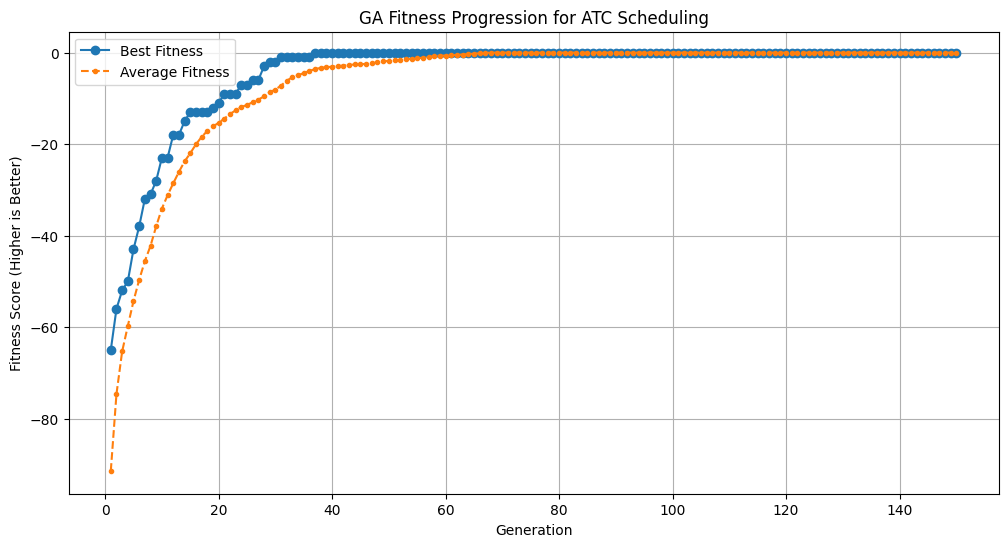

In [12]:
best_schedule, best_fitness, history, avg_history = genetic_algorithm(
    population_size=POPULATION_SIZE,
    num_people=NUM_PEOPLE,
    shifts_per_week=SHIFTS_PER_WEEK,
    shifts_per_day=SHIFTS_PER_DAY,
    days_per_week=DAYS_PER_WEEK,
    generations=GENERATIONS,
    mutation_rate=MUTATION_RATE,
    crossover_rate=CROSSOVER_RATE
)

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
    # Explain and show the plot
    print("\n" + "="*30)
    print("      Fitness Plot Explanation")
    print("="*30)
    print("The plot shows the fitness score evolution over generations:")
    print(" - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.")
    print(" - 'Average Fitness': The average fitness score of all schedules in the population for each generation.")
    print("Ideally, both lines should trend upwards (towards 0 or positive values).")
    print("The gap between average and best fitness indicates population diversity.")
plot_fitness(history, avg_history)

# Q2 Exploring the Solution Space (5 points)

Now that you've written a base genetic algorithm, let's see what additional information you can learn about this problem. Every air traffic controller gets paid the same amount regardless of how many shifts they work. Management wants to find the minimum number of air traffic controllers they need without creating ANY constraint violations.

a. Using your genetic algorithm solver, find the minimum number of air traffic controllers needed.

b. Describe how you came up with your answer to part A and how confident you are in that answer.

In [ ]:
def find_minimum_controllers():
	"""Find the minimum number of controllers needed without constraint violations."""
	for num_controllers in range(3, 8):
		print(f"\nTesting with {num_controllers} controllers...")

		successful_runs = 0
		total_runs = 5

		for trial in range(total_runs):
			best_schedule, best_fitness, _, _ = genetic_algorithm(
				population_size=POPULATION_SIZE,
				num_people=num_controllers,
				shifts_per_week=SHIFTS_PER_WEEK,
				shifts_per_day=SHIFTS_PER_DAY,
				days_per_week=DAYS_PER_WEEK,
				generations=GENERATIONS,
				mutation_rate=MUTATION_RATE,
				crossover_rate=CROSSOVER_RATE
			)

			print(f"  Trial {trial+1}: Best fitness = {best_fitness}")
			if best_fitness == 0:  # No violations
				successful_runs += 1
		
		success_rate = successful_runs / total_runs
		print(f"Success rate with {num_controllers} controllers: {success_rate*100:.0f}%")
		
		# If we consistently find valid solutions, we've found our answer
		if success_rate >= 0.8:
			print(f"\nMinimum number of controllers needed: {num_controllers}")
			return num_controllers
	
	print("Could not find a reliable solution")
	return None

minimum_controllers = find_minimum_controllers()


Testing with 3 controllers...
Gen 0: Best=-41.00, Avg=-59.63
Gen 10: Best=-22.00, Avg=-25.79
Gen 20: Best=-14.00, Avg=-17.08
Gen 30: Best=-12.00, Avg=-12.00
Gen 40: Best=-12.00, Avg=-12.00
Gen 50: Best=-12.00, Avg=-12.00
Gen 60: Best=-12.00, Avg=-12.00
Gen 70: Best=-12.00, Avg=-12.00
Gen 80: Best=-12.00, Avg=-12.00
Gen 90: Best=-12.00, Avg=-12.00
Gen 100: Best=-12.00, Avg=-12.00
Gen 110: Best=-12.00, Avg=-12.00
Gen 120: Best=-12.00, Avg=-12.00
Gen 130: Best=-12.00, Avg=-12.00
Gen 140: Best=-12.00, Avg=-12.00
  Trial 1: Best fitness = -12
Gen 0: Best=-38.00, Avg=-58.84
Gen 10: Best=-20.00, Avg=-24.89
Gen 20: Best=-14.00, Avg=-16.96
Gen 30: Best=-12.00, Avg=-12.00
Gen 40: Best=-12.00, Avg=-12.00
Gen 50: Best=-12.00, Avg=-12.00
Gen 60: Best=-12.00, Avg=-12.00
Gen 70: Best=-12.00, Avg=-12.00
Gen 80: Best=-12.00, Avg=-12.00
Gen 90: Best=-12.00, Avg=-12.00
Gen 100: Best=-12.00, Avg=-12.00
Gen 110: Best=-12.00, Avg=-12.00
Gen 120: Best=-12.00, Avg=-12.00
Gen 130: Best=-12.00, Avg=-12.00
Gen 

# Solution 2

a. Based on the constraints presented by the code:

- Morning shifts require at least 1 controller
- Afternoon shifts require at least 2 controllers
- Night shifts require at least 1 controller
- After morning/afternoon shifts, controllers need 1 shift off
- After night shifts, controllers need 3 shifts off (full day)

After working for a day with 4 controllers, the next day the night shift controller will not be able to work, a spot that will be covered by the afternoon controller. That's when a 5th controller is needed, for the spot of the afternoon controller.

Therefore, we can determine that the solution is to have **5 controllers**.

b. I was able to find the solution through manual testing with pen and paper, based on the contraints. However, I was not sure about it, so I decided to run a script with the solver to confirm it!

# Q3 Tweaking the Parameters (10 points)

Now that you've written a base genetic algorithm, let's see if you can improve the performance by tweaking the parameters. Pick one of the GA Parameters and create a plot showing the results at different values.

In [ ]:
best_schedule, best_fitness, history, avg_history = genetic_algorithm(
        population_size=POPULATION_SIZE, # parameter you could pick to sweep 
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE, # parameter you could pick to sweep 
        crossover_rate=CROSSOVER_RATE, # parameter you could pick to sweep 
    )  # CHECK THE PARAMETERS!!!


# CHANGE THIS CODE BELOW SO THAT IT PLOTS THE PARAMETER THAT GETS SWEEPED

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY, DAYS_PER_WEEK)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
    # Explain and show the plot
    print("\n" + "="*30)
    print("      Fitness Plot Explanation")
    print("="*30)
    print("The plot shows the fitness score evolution over generations:")
    print(" - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.")
    print(" - 'Average Fitness': The average fitness score of all schedules in the population for each generation.")
    print("Ideally, both lines should trend upwards (towards 0 or positive values).")
    print("The gap between average and best fitness indicates population diversity.")
plot_fitness(history, avg_history)

### Interpret

- What parameter did you pick?

- What was optimal value for that parameter and why?

- Is there another parameter do you think that tweaking it's value will improve the results and why?

# Solution 3
todo...

## Q4 Changing Core Operations (15 points)

Finally, we are going to explore other methods for selection, crossover, and mutation. Choose your parent selection, mutation, crossover, or selection function and rewrite it to use a different method. Then, rerun the genetic algorithm and compare the results. Display the comparisons in a graph and interpret the results. You will do this twice; you can pick two different functions or pick the same function and come up with two different versions of it.

Completely optional, but if you are look for some inspiration this paper outlines the success of different kind of selection schemes: [A Comparative Analysis of Selection Schemes
Used in Genetic Algorithms](https://www.cse.unr.edu/~sushil/class/gas/papers/Select.pdf)

- Step/Method you are replacing:

- Step/Method you are replacing it with:

- Interpret the results of this replacement:


In [ ]:
def verison_2():    #replace with the name of the function
    pass


# Copy code above to run and plot this function

- Step/Method you are replacing:

- Step/Method you are replacing it with:

- Interpret the results of this replacement:


In [ ]:
def verison_3():    #replace with the name of the function
    pass

# Copy code above to run and plot this function